In [ ]:
#import all packagaes
from os import path
import csv, random, numpy as np, os, re, nltk, scipy, gensim, string, pandas as pd, copy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from csv import DictReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import pylab as py
from tqdm import tqdm
#from scipy import sparse
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle
from sklearn.neural_network import MLPClassifier

import tensorflow
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime!')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
#METHOD FOR LOADING BODIES
#Input: filename string .csv
#Output: DICTIONARY of Body ID : body text
def bodyLoader (filename):
  reader = list(csv.DictReader(open('/content/drive/MyDrive/FNC/data/'+filename, 'r', encoding='utf-8')))
  bodies = dict()
  for row in reader:
   bodies[int(row['Body ID'])]=row['articleBody']
  return bodies


#METHOD FOR LOADING STANCES + HEADLINES DATA
#Input: filename string .csv
#Output: LIST of DICTIONARIES
#KEYS: Headline, Body ID, Stance
def stanceLoader (filename):
  stances = list(csv.DictReader(open('/content/drive/MyDrive/FNC/data/'+filename, 'r', encoding='utf-8')))
  return stances


#METHOD FOR MERGING BODIES TO STANCE DATA FOR FULL SET
#MODIFIED STANCE SET LIST OF DICTIONARIES to include article body
#Input:
#Output: NO OUTPUT 
#KEYS: Headline, Body ID, Stance, articleBody
def dataMerge (stance_data, bodies):
  for i in range(len(stance_data)):
    key=int(stance_data[i]['Body ID'])
    body_entry = {'articleBody': bodies[key]}
    stance_data[i].update(body_entry)
  #return stance_data

In [ ]:
#LOAD TRAINING DATA
train_bodies = bodyLoader("train_bodies.csv")
train_stances = stanceLoader("train_stances.csv")
dataMerge(train_stances, train_bodies)
training_data = train_stances
training_data[:1]

[OrderedDict([('Headline',
               "Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash"),
              ('Body ID', '712'),
              ('Stance', 'unrelated'),
              ('articleBody',
               'Danny Boyle is directing the untitled film\n\nSeth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.\n\nDanny Boyle is directing the untitled film, based on Walter Isaacson\'s book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.\n\nNegotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.\n\nOf course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.\n\n

In [ ]:
#LOAD TESTING DATA
test_bodies = bodyLoader("competition_test_bodies.csv")
test_stances = stanceLoader("competition_test_stances.csv")
dataMerge(test_stances, test_bodies)
testing_data = test_stances
testing_data[:3]

[OrderedDict([('Headline',
               'Ferguson riots: Pregnant woman loses eye after cops fire BEAN BAG round through car window'),
              ('Body ID', '2008'),
              ('Stance', 'unrelated'),
              ('articleBody',
               'A RESPECTED senior French police officer investigating the Charlie Hebdo magazine massacre took his own life mere hours after the horrific attacks stunned the world.\n\nCommissioner Helric Fredou, 45, turned a gun on himself in his police office in Limoges last Wednesday night, reported France 3.\n\nA colleague found his body at 1am on Thursday, the day after three gunmen fired at the satirical magazine\'s office and left 12 people dead.\n\nSpeaking to our sister publication Mirror Online, the Union of Commissioners of the National Police confirmed Mr Fredou had taken his own life.\n\n\nIn a statement released after his death, a union spokesman said: "It is with great sadness that we were informed this morning of the death of our col

In [ ]:
#method for getting bodies
def get_bodies(dataset):
    bodies = []
    for element in dataset:
        bodies.append(element['articleBody'])
    return bodies

#method for getting headlines
def get_heads(array):
    headlines = []
    for element in (array):
        headlines.append(element['Headline'])
    return headlines

In [ ]:
#get bodies and headlines for datasets
#Needed for the vectors in next step
bodies_train = get_bodies(training_data)
heads_train = get_heads(training_data)
bodies_test = get_bodies(testing_data)
heads_test = get_heads(testing_data)


for i in range(3):
  print(heads_test[i])
  print('\n')
  print(bodies_test[i])
  print('\n--END--\n\n\n')


Ferguson riots: Pregnant woman loses eye after cops fire BEAN BAG round through car window


A RESPECTED senior French police officer investigating the Charlie Hebdo magazine massacre took his own life mere hours after the horrific attacks stunned the world.

Commissioner Helric Fredou, 45, turned a gun on himself in his police office in Limoges last Wednesday night, reported France 3.

A colleague found his body at 1am on Thursday, the day after three gunmen fired at the satirical magazine's office and left 12 people dead.

Speaking to our sister publication Mirror Online, the Union of Commissioners of the National Police confirmed Mr Fredou had taken his own life.


In a statement released after his death, a union spokesman said: "It is with great sadness that we were informed this morning of the death of our colleague Helric Fredou, assigned as Deputy Director of the Regional Service Judicial Police in Limoges.

"On this particular day of national mourning, police commissioners are 

In [ ]:
##THINGS TO TRY
##WORD EMBEDDINGS
#Embed against word2vec
#use against to "replace" Tf, Could also just add it as a feature, could also do cosinesimilarity

In [ ]:
## VECTORIZER PARAMETERS
n_features = 5000
stop_list =[]


In [ ]:
## NEW VECTOR 
#TRAIN TERM FREQUENCY
tf_vectorizer = TfidfVectorizer(use_idf=False, strip_accents='ascii', ngram_range=(1,1), max_features=n_features, stop_words='english').fit(heads_train + bodies_train)

#TRAIN  TF_IDF VECTOR
#NO TEST - DIFFERENT FROM BEFORE
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,1), max_features=n_features, stop_words='english').fit(heads_train + bodies_train)


In [ ]:
#MAIN PIPELINE
##METHOD FOR GETTING THE FEATURE TF ARRAY AND STANCES FOR DATA SET (Training or Test)
#USES VECTORS CALCULATED ABOVE
#OUTPUT: returns dataset features (X) and stances (Y)

label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_inv = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}

def Pipeline (dataset):

  data_set=[]
  data_stances=[]

  for instance in dataset:
    head = instance['Headline']
    body_id = instance['Body ID']
    body_text = instance['articleBody']

    #Get head and body TF
    head_tf = tf_vectorizer.transform([head]).toarray()
    body_tf = tf_vectorizer.transform([body_text]).toarray()

    #Get head and body TF-IDF
    head_tfidf = tfidf_vectorizer.transform([head]).toarray()
    body_tfidf = tfidf_vectorizer.transform([body_text]).toarray()

    #Calculate Cosime Similarity between head and body of instance
    tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)

    #add Feature Vec
    feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    data_set.append(feat_vec)
    data_stances.append(label_ref[instance['Stance']])
  
  return data_set, data_stances


In [ ]:
X_train, y_train = Pipeline(training_data)
X_test, y_test = Pipeline(testing_data)
print(len(X_train), len(y_train), len(X_test), len(y_test))

49972 49972 25413 25413


In [ ]:
## RESULTS REPORT METHOD
#always uses y_test as the answers, only need to pass predictions
def Results (predictions):
  #define confusion matrix
  cnf_matrix = metrics.confusion_matrix(y_test, predictions)
  cnf_matrix
  class_names=['agree', 'disagree', 'discuss', 'unrelated'] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  #Report accuracy
  print("Accuracy:",metrics.accuracy_score(y_test, predictions))
  print("Precision:",metrics.precision_score(y_test, predictions, average='weighted'))
  print("Recall:",metrics.recall_score(y_test, predictions, average='weighted'))

In [ ]:
## --- MODELS BELOW --- ##

#X_train, y_train, X_test, y_test are used from above and passed to the models below

In [ ]:
## 2 stage LOGIC

#GET DATA FOR STAGE 1 TRAINING
#related or unrelated ONLY
#TRAIN

#GET DATA FOR STAGE 2 TRAINING
#no unrelated-  ONLY agrees, disagrees, discusses
#TRAIN

#PASS ALL TEST DATA TO FIRST MODEL

#SEND RELATED PREDICTIONS ONLY TO SECOND MODEL to PREDICT ACTUAL LABEL

#PUT ALL PREDICTIONS BACK TOGETHER

X_train[1]

In [ ]:
##Prepare data for model 1 training
#same X_train will be fine

X_train_1 = X_train
y_train_1 = copy.deepcopy(y_train)

for i, stance in reversed(list(enumerate(y_train_1))):
  if stance == 3:
    continue
  else:
    y_train_1[i] = 4

y_train_1[:10]

[3, 4, 3, 3, 4, 4, 3, 3, 4, 3]

In [ ]:
##Prepare data for model 2 training
#Removing rows from both X and y sets

X_train_2 = copy.deepcopy(X_train) #takes some time
y_train_2 = copy.deepcopy(y_train)
#removed_ref = []

#NEED TO DELETE IN REVERSE
for i, stance in reversed(list(enumerate(y_train_2))):
  if stance == 3:
    del X_train_2[i]
    del y_train_2[i]
    #removed_ref.append(i)
  else:
    continue

In [ ]:
print(len(X_train_2))
print(len(y_train_2))
#print(removed_ref)
y_train_2

13427
13427


[0,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,


In [ ]:
#TRAIN MODEL 1

#Logistic Regression model
logreg1 = LogisticRegression(max_iter=100)

#FIT MODEL
logreg1.fit(X_train_1, y_train_1)


LogisticRegression()

In [ ]:
#TRAIN MODEL 2

#Logistic Regression model
logreg2 = LogisticRegression(max_iter=100)

#FIT MODEL
logreg2.fit(X_train_2, y_train_2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
#Generate predictions MODEL 1
y_pred_1 = list(logreg1.predict(X_test))

#Results(y_pred_1)
print(len(X_test))
print(len(y_pred_1))
y_pred_1

25413
25413


[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,


In [ ]:
##GET ROWS TO PASS TO SECOND MODEL
X_test_2 = copy.deepcopy(X_test)
y_pred_mid = copy.deepcopy(y_pred_1)
removed_ref = []

for i, stance in reversed(list(enumerate(y_pred_mid))):
  if stance == 3:
    del X_test_2[i]
    del y_pred_mid[i]
    removed_ref.append(i)
  else:
    continue

print(removed_ref)

[25412, 25410, 25407, 25406, 25404, 25403, 25402, 25401, 25400, 25399, 25398, 25397, 25396, 25395, 25394, 25393, 25392, 25391, 25390, 25389, 25388, 25387, 25386, 25385, 25384, 25383, 25382, 25381, 25379, 25375, 25373, 25372, 25371, 25366, 25362, 25361, 25359, 25325, 25320, 25288, 25287, 25286, 25285, 25258, 25252, 25250, 25242, 25241, 25240, 25239, 25238, 25237, 25236, 25235, 25234, 25233, 25232, 25231, 25230, 25229, 25228, 25227, 25226, 25225, 25224, 25214, 25213, 25211, 25210, 25209, 25208, 25207, 25202, 25200, 25199, 25198, 25197, 25196, 25195, 25194, 25193, 25181, 25179, 25175, 25173, 25152, 25151, 25150, 25145, 25144, 25143, 25142, 25140, 25139, 25138, 25137, 25136, 25134, 25133, 25132, 25131, 25130, 25129, 25127, 25126, 25124, 25123, 25122, 25121, 25120, 25118, 25117, 25116, 25115, 25114, 25113, 25112, 25111, 25108, 25107, 25106, 25105, 25104, 25103, 25102, 25100, 25098, 25097, 25096, 25095, 25093, 25092, 25091, 25090, 25088, 25086, 25084, 25082, 25081, 25080, 25079, 25077, 25076

In [ ]:
#Generate predictions MODEL 2
y_pred_2 = list(logreg2.predict(X_test_2))

#Results(y_pred_1)
print(len(X_test_2))
print(len(y_pred_2))
y_pred_2

5619
5619


[2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:
#COMBINE PREDICTIONS
y_pred_f = copy.deepcopy(y_pred_1)
i2 = 0 #iterator through only y_pred_2
for i, pred in enumerate(y_pred_f):
  if pred == 4:
    y_pred_f[i]= y_pred_2[i2]
    i2+=1

print(i2)
print(y_pred_f)


5619
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 0, 0, 3, 0, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 0, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 2, 3, 0, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2

Accuracy: 0.8618423641443356
Precision: 0.8422552327584721
Recall: 0.8618423641443356


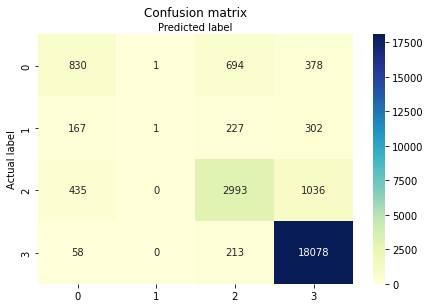

In [ ]:
Results(y_pred_f)

In [ ]:
## METHOD TO SAVE PREDICTIONS TO FILE
def answerCSV (predictions, savename):
  with open('/content/drive/MyDrive/FNC/data/competition_test_stances_unlabeled.csv', 'r', encoding='utf-8') as rf:
    with open('/content/drive/MyDrive/FNC/data/'+savename, 'w', encoding='utf-8') as wf:
      reader = csv.reader(rf)
      writer = csv.writer(wf)
      headers = next(reader)
      headers.append("Stance")
      writer.writerow(headers)
      for i, row in enumerate(reader):
        row.append(label_ref_inv[predictions[i]])
        writer.writerow(row)

In [ ]:
answerCSV(y_pred_f, "answer2.csv")

Accuracy: 0.8588517687797584
Precision: 0.851183533718227
Recall: 0.8588517687797584


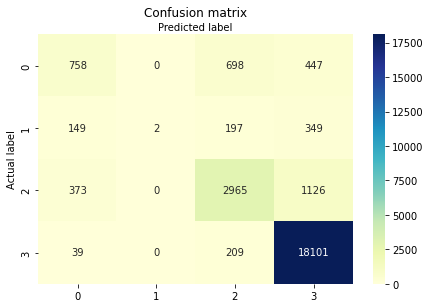

In [ ]:
##LOGISTIC REGRESSION
#MODEL DEFINITION AND TRAINING

#Logistic Regression model (using the default parameters)
#default parameters seem to perform quite well
logreg = LogisticRegression(max_iter=200)
#weight balanced nogood
#logreg = LogisticRegression(class_weight='balanced', max_iter=300 )

#FIT MODEL
logreg.fit(X_train,y_train)

#Generate predictions
y_pred=logreg.predict(X_test)

Results(y_pred)

In [ ]:
y_pred

array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
##SAVE PREDICTIONS TO FILE
with open('/content/drive/MyDrive/FNC/data/competition_test_stances_unlabeled.csv', 'r', encoding='utf-8') as rf:
  with open('/content/drive/MyDrive/FNC/data/answer.csv', 'w', encoding='utf-8') as wf:
    reader = csv.reader(rf)
    writer = csv.writer(wf)
    headers = next(reader)
    headers.append("Stance")
    writer.writerow(headers)
    for i, row in enumerate(reader):
      row.append(label_ref_inv[y_pred[i]])
      writer.writerow(row)


In [ ]:
#OLD
reader = csv.reader(open('/content/drive/MyDrive/FNC/data/competition_test_stances_unlabeled.csv', 'r', encoding='utf-8'))
writer = csv.writer(open('/content/drive/MyDrive/FNC/data/answers.csv', 'w', encoding='utf-8'))
headers = next(reader)
headers.append("Stance")
writer.writerow(headers)
for i, row in enumerate(reader):
    row.append(label_ref_inv[y_pred[i]])
    writer.writerow(row)

In [ ]:
#THIS IS USED FOR THE NEURAL NET
#Converting format
X_train2 = np.stack(X_train)
y_train2 = np.array(y_train)
X_test2 = np.stack(X_test)
y_test2 = np.array(y_test)

In [ ]:
#Also used below for NN Model
n_features = len(X_train[0])
n_features

10001

In [ ]:
print(X_train2.shape)
print(y_train2.shape)

(49972, 10001)
(49972,)


In [ ]:
##NEURAL NETWORK MODEL MLP
model = Sequential()
model.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
#model.add(Dense(24, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(4, activation='softmax'))

model.summary()

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #DENSE
# fit the model
model.fit(X_train2, y_train2, epochs=20, batch_size=200, verbose=0)
# evaluate the model
loss, acc = model.evaluate(X_test2, y_test2, verbose=0)
print('Test Accuracy: %.3f' % acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160032    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
Total params: 160,204
Trainable params: 160,204
Non-trainable params: 0
_________________________________________________________________
Test Accuracy: 0.832


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: 0.849092983905875
Precision: 0.825970120483247
Recall: 0.849092983905875


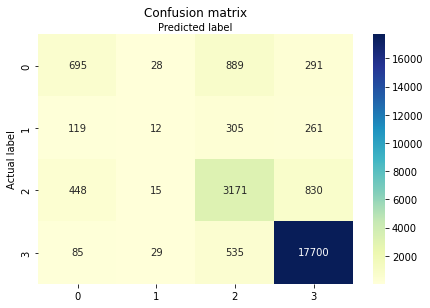

In [ ]:
## MLP CLASSIFIER
#MODEL DEFINITION AND TRAINING

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
clf.score(X_test, y_test)

Results(pred)

In [ ]:
#THINGS TO TRY
#Random forest 100-200
#Other tree based
#SVM?

##TWO STAGE
#run simpler models on less data
#try Neural Net for both